In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMClassification'

predict_n = 5

THRESH_DIFF = None

In [4]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=THRESH_DIFF,
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.614097,0.394439,0.553595,0.544670,higher,0.014705,higher
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.613560,0.394997,0.552214,0.528665,lower,0.014610,lower
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.613056,0.395653,0.552076,0.527143,higher,0.014280,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.612481,0.396346,0.551593,0.521630,lower,0.013823,lower
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.611450,0.397285,0.549730,0.499895,lower,0.013005,lower


In [5]:
y_column = 'Next'
seq_len = 5
n_splits=10
val_size = 0.2

features = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 
            'EMA(14)', 'SMA(10)', 'SMA(20) - SMA(10)','PercentageDiff', 'LowLen', 'RSI_diff', 'BodyLen', 'Volume_diff']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(10, 6)

<AxesSubplot:>

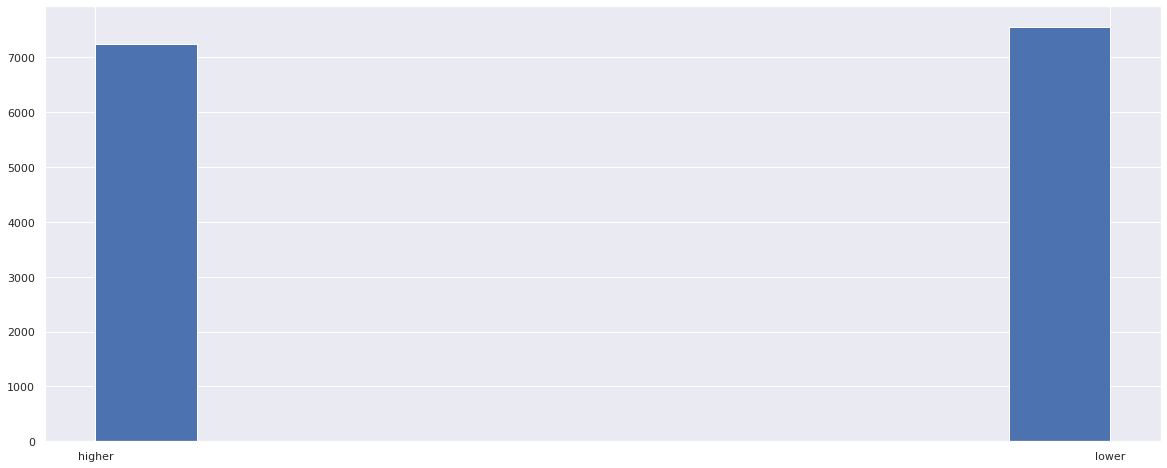

In [6]:
data_wrapper[y_column].hist()

In [ ]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_classification_trainer import KerasClassificationTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 500,
    n_splits = n_splits,
    val_size = val_size,
)

group_name = f"[{quotation}] {seq_len}-sequences : {len(features)} features  -> predict:{predict_n}, {n_splits} splits {val_size} val"


for split_id, split in tqdm(enumerate(datasets_splits)):
    #run = wandb.init(project='StockRegressionKerasLSTM', config=config_dict, group=group_name, name=f"Split {split_id+1}")
    
    (X_train, X_val, X_test, y_train, y_val, y_test) = split
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config_dict['batch_size'])
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

    model = LSTMModel(config_dict, seq_len, len(features), output_dim=len(np.unique(y_train)),
                      learning_rate=config_dict['learning_rate'], loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    trainer = KerasClassificationTrainer(model, project_label=project_label)
    trainer.train(train_set, val_set)

0it [00:00, ?it/s]

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/tzhh0w1g
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/9gs9dagp
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/1u088f52
Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification/runs/1dmxk2o4


### Train model with full training set (train + validation) and test on test set

In [8]:
config_dict['n_epochs'] = 150

full_train_set = train_set.concatenate(val_set)
final_model = LSTMModel(config_dict, seq_len, len(features), output_dim=len(np.unique(y_train)),learning_rate=config_dict['learning_rate'], loss='mse')
trainer = KerasClassificationTrainer(model, project_label=f"{project_label} full training-set")
trainer.train(full_train_set, val_set=test_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMClassification%20full%20training-set/runs/1ipc4jwo


{'accuracy': 0.5193452380952381,
 'roc_auc': 0.5154245323831984,
 'f1_score': 0.51549403127633,
 'confusion_matrix': <wandb.sdk.data_types.Image at 0x1ad9cdc8408>}

In [9]:
from helpers.plots_helper import plot_heatmap

predictions, labels = trainer.predict(test_set)
predictions = predictions.argmax(axis=1)
plot_heatmap(labels=labels, predictions=predictions, class_labels=['higher', 'stay', 'lower'])

ValueError: Shape of passed values is (2, 2), indices imply (3, 3)